In [2]:
from collections import Counter
from functools import partial

import numpy as np
rng = np.random.default_rng()
np.set_printoptions(suppress=True, linewidth=180, edgeitems=5)
from tqdm.notebook import tqdm, trange
from tqdm.contrib.concurrent import process_map

from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Setup

In [394]:
# ns = [0,10,10,11,12,13,14,15,16,17]
# ns = [0,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# ns = [0]




# ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
# ms = 5
# # arrs = np.array([[20,0,0,0,0],
# #                  [19,19,0,0,0],
# #                  [18,18,18,0,0],
# #                  [17,17,17,17,0],
# #                  [16,16,16,16,16],])
# arrs = np.array([[20,0,0,0,0],
#                  [15,16,17,18,19],
#                  [0,0,0,0,0],
#                  [0,0,0,0,0],
#                  [0,0,0,0,0],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                 ])
# arrs = arrs / 20
# display(arrs)
# display(arrs.sum().round(2))

ms = 2

if ms == 10:
    students = np.logspace(-2, 1, 13)
    ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
    arrs = np.array([[1,0,0,0,0,0,0,0,0,0],
                     [.95,.9,.85,.8,.75,.7,.65,.6,.55,.5],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                     # [-10,-10,-10,-10,-10,-10,-10,-10,-10,-10],
                    ])
    display(arrs)
    display(arrs.sum().round(2))
                 
elif ms == 2:
    students = np.logspace(-2, 2, 17)
    ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
    arrs = np.array([[1,0],[.95,.90]])
    display(arrs)
    display(arrs.mean().round(2))


ranked = False
top2 = True


slip = False
# students = np.linspace(0.05, 0.5, 10)

display(students.round(3))

array([[1.  , 0.  ],
       [0.95, 0.9 ]])

0.71

array([  0.01 ,   0.018,   0.032,   0.056,   0.1  ,   0.178,   0.316,   0.562,   1.   ,   1.778,   3.162,   5.623,  10.   ,  17.783,  31.623,  56.234, 100.   ])

In [395]:
def make_model(num_nodes=128, num_dense=4):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    
    inputs = tf.keras.layers.Input(shape=(ms*ms + ms + 1))
    x = tf.keras.layers.Flatten()(inputs)
    for _ in range(num_dense):
        x = tf.keras.layers.Dense(num_nodes, activation='relu')(x)
    output1 = tf.keras.layers.Dense(ms, name='Y0')(x)
    output1 = tf.keras.layers.Softmax()(output1)
    model = tf.keras.models.Model(inputs=inputs, outputs=output1)
    
    opt = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    return model

def softmax(x, b, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    return np.exp(x/b) / np.exp(x/b).sum(axis=axis, keepdims=True)

def make_x():
    x = arrs
    
    # rand = np.random.random(arrs.shape)
    # rand = (rand - 0.5)
    # x = x + rand*0.0001
    
    x = rng.permuted(x, axis=-1)
    return x

def eval_model(model, n = 1, disable=True):
    rewards = []
    branch_rewards = []
    for _ in trange(n, disable=disable):
        x = make_x()
        x_tree = np.concatenate([np.eye(ms+1).astype(int), np.tile(x.flatten(), (ms+1,1))], axis=1)
        y_pred = model(x_tree).numpy()
        
        if top2:
            y_pred[0,2:] = 0
            y_pred[0] = y_pred[0] / y_pred[0].sum()
        
        branch_reward = (x_tree[0,ms+1:].reshape(ms,ms) * y_pred[1:]).sum(axis=1)
        rewards.append(y_pred[0])
        # reward = (y_pred[0] * branch_reward).numpy().sum()
        # rewards.append(reward)
        branch_rewards.append(branch_reward)
    return np.array(rewards), np.array(branch_rewards)

def make_data(b=1, n=1, disable=True):
    X, Y = [], []
    for _ in trange(n, disable=disable):
        
        if ranked:
            x = make_x()
            r1 = softmax(rankdata(x,axis=1), b)
            r1sum = (r1*x).sum(axis=1)
            r0 = softmax(rankdata(r1sum), b)
                    
        else:
            x = make_x()
            r1 = softmax(x, b)
            r1sum = (r1*x).sum(axis=1)
            r0 = softmax(r1sum, b)
        
        pos = [0] * (ms+1)
        pos[0] = 1
        x0 = pos + list(x.flatten())
        
        
        # slip_prob = np.log10(b)/-20 + 0.95
        slip_prob = b
        
        if slip == False:
            if top2:
                p = np.zeros_like(r0)
                p[:2] = r0[:2]
                p = p / p.sum()
            else:
                p = r0
            y0 = rng.choice(np.arange(ms), p=p)
        else:
            if top2:
                p = np.zeros_like(r0)
                p[0:2] = [1-slip_prob, slip_prob]
            else:
                p = np.zeros_like(r0)
                p[0] = 1-slip_prob
                p[1:] = slip_prob/(ms-1)
            y0 = rng.choice(np.arange(ms), p=p)
        # while y0 in [2,3,4]:
        #     y0 = rng.choice(np.arange(ms), p=r0)
            
        
        pos = [0] * (ms+1)
        pos[y0+1] = 1
        x1 = pos + list(x.flatten())
        
        if slip == False:
            y1 = rng.choice(np.arange(ms), p=r1[y0])
        else:
            p = np.zeros(ms) + (slip_prob)/(ms-1)
            p[r1.argmax()] = 1 - slip_prob
            y1 = rng.choice(np.arange(ms), p=p)

        X.append(x0)
        Y.append(y0)
        X.append(x1)
        Y.append(y1)
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X,Y

In [396]:
%%time
for b in students:
    r0s = []
    r1s = []
    for _ in trange(10000, disable=True):
        x = make_x()
        
        if ranked:
            r1 = (softmax(rankdata(x,axis=1), b) * x).sum(axis=1)
            r0 = (softmax(rankdata(r1), b) * r1).sum()
            r1s.append(r1)
            r0s.append(r0)
            
        else:
            r1 = (softmax(x, b) * x).sum(axis=1)
            r0 = (softmax(r1, b) * r1).sum()
            r1s.append(r1)
            r0s.append(r0)
    
        
    r1s = np.array(r1s)
    r0s = np.array(r0s)
    print(f"{b:.3f}, {r0s.mean():.3f}, {r1s.mean(axis=0).round(3)}, {softmax(r1s.mean(axis=0), b).round(3)}")

0.010, 1.000, [1.   0.95], [0.994 0.006]
0.018, 0.997, [1.    0.947], [0.951 0.049]
0.032, 0.992, [1.    0.941], [0.864 0.136]
0.056, 0.984, [1.    0.935], [0.759 0.241]
0.100, 0.977, [1.    0.931], [0.666 0.334]
0.178, 0.969, [0.996 0.928], [0.594 0.406]
0.316, 0.944, [0.959 0.927], [0.526 0.474]
0.562, 0.893, [0.855 0.926], [0.469 0.531]
1.000, 0.838, [0.731 0.926], [0.452 0.548]
1.778, 0.793, [0.637 0.925], [0.46 0.54]
3.162, 0.761, [0.578 0.925], [0.473 0.527]
5.623, 0.741, [0.544 0.925], [0.483 0.517]
10.000, 0.729, [0.525 0.925], [0.49 0.51]
17.783, 0.722, [0.514 0.925], [0.494 0.506]
31.623, 0.718, [0.508 0.925], [0.497 0.503]
56.234, 0.716, [0.504 0.925], [0.498 0.502]
100.000, 0.714, [0.502 0.925], [0.499 0.501]
CPU times: user 5.24 s, sys: 73.2 ms, total: 5.32 s
Wall time: 5.32 s


In [313]:
def train_model(i, student):
    verbose = False
    if student == 1:
        print(f'student == {student:.3f}')
        verbose = True
    model = make_model()
    Xtrain, Ytrain = make_data(student, 2**16, disable=not verbose)
    model.fit(Xtrain, Ytrain, verbose=verbose)
    reward = eval_model(model, 10000, disable=not verbose)
    model.save(f'models/2x{ms}/starting_{student:.3f}_{i}.keras')
    # model.save_weights(f'models/starting_{student:.3f}_{i}.weights.h5')
    return reward

In [316]:
%%time

iters = list(range(10))
iter_students = [100 for i in iters]
rewards = process_map(train_model, iters, iter_students, disable=False, max_workers=20)

# rewards = process_map(train_model, students, disable=True, max_workers=17)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 43 ms, sys: 403 ms, total: 446 ms
Wall time: 1min 8s


In [317]:
for r, s in zip(rewards, students):
    
    res = r[0]*r[1]
    res = res.sum(axis=1).mean()
    
    print(f"{s:.3f} {res}")

0.010 0.3975234003647207
0.018 0.4103889367690447
0.032 0.41277275320652207
0.056 0.41752487291469825
0.100 0.4070430208012689
0.178 0.41448444346646074
0.316 0.4435747295870692
0.562 0.3974087653521134
1.000 0.4030036393175212
1.778 0.39106854054059814


In [401]:
%%time
ntotal = (2**np.array(ns[1:13])).sum()

currs = process_map(make_data, students, [ntotal]*len(students), max_workers=17, chunksize=1)
currs = dict(zip([f"{s:.3f}" for s in students], currs))

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 110 ms, sys: 582 ms, total: 692 ms
Wall time: 9.64 s


# Eval Training

In [855]:
def eval_training(modeli, student, teachers, save, pct=0):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.get_logger().setLevel('ERROR')
    
    def get_r(model):
        r0, r1 = eval_model(model, 10)
        r = (r0*r1).sum(axis=1).mean()
        return r
        
    class CustomCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            super(CustomCallback, self).__init__()
        def on_batch_begin(self, batch, logs=None):
            if save and batch % 1 == 0:
                r = get_r(self.model)
                try:
                    self.model.rewards[batch] = r
                except:
                    self.model.rewards = {batch: r}
    
    if student == -1:
        model2 = make_model()
    else:
        model2 = tf.keras.models.load_model(f"models/2x{ms}/starting_{student:.3f}_{modeli%10}.keras")
        
    opt = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model2.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    
    bs = 32
    
    rng = np.random.default_rng(modeli)
    
    X, Y = [], []
    for teacher, n in teachers:
        if isinstance(teacher, tuple):
            X.append([])
            Y.append([])
            for teacher_part in teacher:
                _X, _Y = currs[f"{teacher_part:.3f}"]
                perm = np.random.default_rng(modeli).permutation(len(_X))[:bs * n//len(teacher)]
                # perm = np.random.permutation(len(_X))[:bs * n//len(teacher)]
                X[-1].append(_X[perm])
                Y[-1].append(_Y[perm])
            X[-1] = np.concatenate(X[-1])
            Y[-1] = np.concatenate(Y[-1])
            perm = np.random.permutation(len(X[-1]))
            X[-1] = X[-1][perm]
            Y[-1] = Y[-1][perm]
        else:
            _X, _Y = currs[f"{teacher:.3f}"]
            perm = np.random.permutation(len(_X))[:n*bs]
            X.append(_X[perm])
            Y.append(_Y[perm])

    lx = len(X[0])
    if pct:
        assert (pct*lx) % 1 == 0
        pct2 = int(pct * lx)
        mixX = np.concatenate([_X[lx-pct2:] for _X in X])
        mixY = np.concatenate([_Y[lx-pct2:] for _Y in Y])
        for i, (_X, _Y) in enumerate(zip(X, Y)):
            _X[lx-pct2:] = mixX[i::len(X)]
            _Y[lx-pct2:] = mixY[i::len(Y)]
            perm = np.random.permutation(lx)
            _X[:] = _X[perm]
            _Y[:] = _Y[perm]
    
    X, Y = np.concatenate(X), np.concatenate(Y)        
    model2.fit(X, Y, verbose=False, shuffle=False, batch_size=bs, callbacks=[CustomCallback()]) 
    
    final_reward = get_r(model2)
    try:
        model2.rewards[len(X)//bs] = final_reward
    except:
        model2.rewards = {len(X)//bs: final_reward}
        
        
    with open('/storage1/fs1/chien-ju.ho/Active/gym/tree.txt', 'a') as f:
        for k, v in model2.rewards.items():
            print(f"{student};{teachers};{pct};{modeli};{k};{v}", file=f, flush=True)

    return (modeli, student, teachers, model2.rewards)


In [856]:
def exp(student, verbose=True, n=20, nb=100, mode='one', algo=None, pct=0):
        
    if mode == 'one':
        teachers = [
            [(0.010, nb)],
            [(0.032, nb)],
            [(0.100, nb*3)],
            [(0.316, nb)],
            [(1.000, nb)],
            [(3.162, nb)],
            [(10.000, nb)],
        ]
        
    elif mode == 'two-1':
        teachers = [
            [((0.010,0.100,1.000,10.00), nb)],
            [((10.00,1.000), nb//2), ((0.100,0.010), nb//2)],
            [(10.00, nb//4), (1.000, nb//4), (0.100, nb//4), (0.010, nb//4)],
        ]
    elif mode == 'two-2':
        teachers = [
            [((10.00,1.000), nb//2), ((0.100,0.010), nb//2)],
        ]
        
    elif mode == 'three-1':
        teachers = [[(0.1, i), (0.01, i)] for i in range(1, nb//2+1)]
    elif mode == 'three-2':
        teachers = [[(0.1, i*2), (0.01, i)] for i in range(1, nb//2+1)]
    elif mode == 'three-3':
        teachers = [[(0.1, i*3), (0.01, i)] for i in range(1, nb//2+1)]
        
    elif mode == 'algo':
        # teachers = [
        #     [(0.100, nb*.20)]*1 + [(0.010, nb1)] * 9,
        #     [(0.100, nb*.20)]*2 + [(0.010, nb1)] * 8,
        #     [(0.100, nb*.20)]*3 + [(0.010, nb1)] * 7,
        #     [(0.100, nb*.20)]*4 + [(0.010, nb1)] * 6,
        #     [(0.100, nb*.20)]*5 + [(0.010, nb1)] * 5,
        #     [(0.100, nb*.20)]*6 + [(0.010, nb1)] * 4,
        #     [(0.100, nb*.20)]*7 + [(0.010, nb1)] * 3,
        #     [(0.100, nb*.20)]*8 + [(0.010, nb1)] * 2,
        #     [(0.100, nb*.20)]*9 + [(0.010, nb1)] * 1,
        # ]
        
        n1, n2, n3 = algo
        t1, t2 = 0.100, 0.010
        
        teachers = [
            [(t1, n1*2), (t1, n3*2), (t2, n2)],
            [(t1, n1*2), (t2, n2), (t2, n3)],
        ]
        
    elif mode == 'solution':
        teachers = []
        for i in range(0,11):
            teachers.append([(0.100, nb*0.1*2)]*i + [(0.010, nb*0.1)]*(10-i))
        
    
    t_, s_, iters, saves, pcts = [], [], [], [], []
    for teacher in teachers:
        for i in range(n):
            t_.append([(t1, int(t2)) for t1, t2 in teacher])
            s_.append(student)
            iters.append(i)
            if mode.startswith('three') or mode in ['algo', 'solution']:
                saves.append(False)
            else:
                saves.append(True)
                
            pcts.append(pct)
        
    res = process_map(eval_training, iters, s_, t_, saves, pcts, max_workers=21, chunksize=1)
    return res

In [857]:
args = []
for mode in ['one','two-1','three-1','three-2','three-3']:
    args.append([mode, 0])
    
for pct in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    args.append(['two-2', pct])

args

[['one', 0],
 ['two-1', 0],
 ['three-1', 0],
 ['three-2', 0],
 ['three-3', 0],
 ['two-2', 0],
 ['two-2', 0.2],
 ['two-2', 0.4],
 ['two-2', 0.6],
 ['two-2', 0.8],
 ['two-2', 1]]

In [858]:
%%time
for mode, pct in args:
    _ = exp(100, n=10, nb=100, mode=mode, pct=pct)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 1.6 s, sys: 7.23 s, total: 8.84 s
Wall time: 3min 17s


In [873]:
df = pd.read_csv('/storage1/fs1/chien-ju.ho/Active/gym/tree.txt',
                 names=['Student','Teacher','Pct','Exp','Batch','Perf'],
                 sep = ';')
df1 = df.groupby(['Student','Teacher','Pct','Batch','Exp']).Perf.mean().reset_index()
df1 = df1.groupby(['Student','Teacher','Pct','Batch']).Perf.agg(['mean','std','sem','count']).reset_index()
df1 = df1.rename(columns={'mean':'Perf', 'std':'SD', 'sem':'SE'})
df1

,Student,Teacher,Pct,Batch,Perf,SD,SE,count
0,100,"[((0.01, 0.1, 1.0, 10.0), 100)]",0,0,0.713291,0.001522,0.000481,10
1,100,"[((0.01, 0.1, 1.0, 10.0), 100)]",0,1,0.713007,0.001380,0.000436,10
2,100,"[((0.01, 0.1, 1.0, 10.0), 100)]",0,2,0.712788,0.001298,0.000411,10
3,100,"[((0.01, 0.1, 1.0, 10.0), 100)]",0,3,0.713057,0.001648,0.000521,10
4,100,"[((0.01, 0.1, 1.0, 10.0), 100)]",0,4,0.712804,0.001550,0.000490,10
...,...,...,...,...,...,...,...,...
1810,100,"[(3.162, 100)]",0,96,0.719305,0.007137,0.002257,10
1811,100,"[(3.162, 100)]",0,97,0.719345,0.006702,0.002119,10
1812,100,"[(3.162, 100)]",0,98,0.719247,0.006832,0.002161,10
1813,100,"[(3.162, 100)]",0,99,0.720147,0.008270,0.002615,10


In [881]:
df

,Student,Teacher,Pct,Exp,Batch,Perf
0,100,"[(0.032, 100)]",0,7,0,0.715122
1,100,"[(0.032, 100)]",0,7,1,0.714301
2,100,"[(0.032, 100)]",0,7,2,0.713700
3,100,"[(0.032, 100)]",0,7,3,0.714427
4,100,"[(0.032, 100)]",0,7,4,0.713833
...,...,...,...,...,...,...
19655,100,"[((10.0, 1.0), 50), ((0.1, 0.01), 50)]",1600,1,96,0.875018
19656,100,"[((10.0, 1.0), 50), ((0.1, 0.01), 50)]",1600,1,97,0.877620
19657,100,"[((10.0, 1.0), 50), ((0.1, 0.01), 50)]",1600,1,98,0.883842
19658,100,"[((10.0, 1.0), 50), ((0.1, 0.01), 50)]",1600,1,99,0.883459


In [877]:
subs = {}
nb = 100

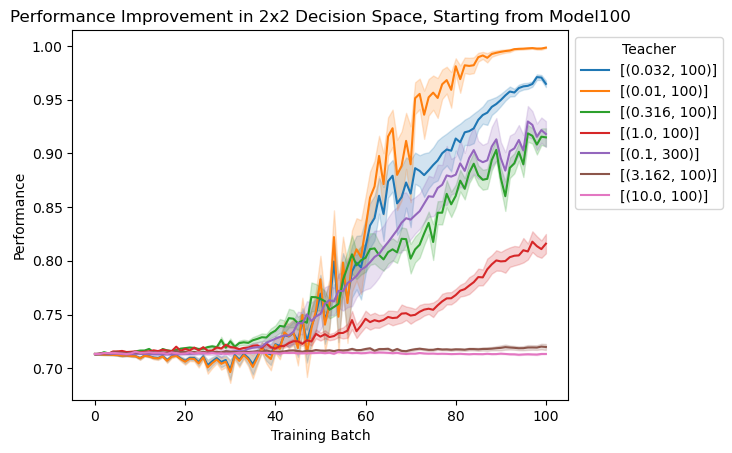

In [931]:
subs['one'] = [str([(k, int(v)) for k,v in i]) for i in [
    [(0.010, nb)],
    [(0.032, nb)],
    [(0.100, nb*3)],
    [(0.316, nb)],
    [(1.000, nb)],
    [(3.162, nb)],
    [(10.000, nb)],
]]

df2 = df[df.Teacher.isin(subs['one'])]
df2 = df2[df2.Batch <= 100]

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

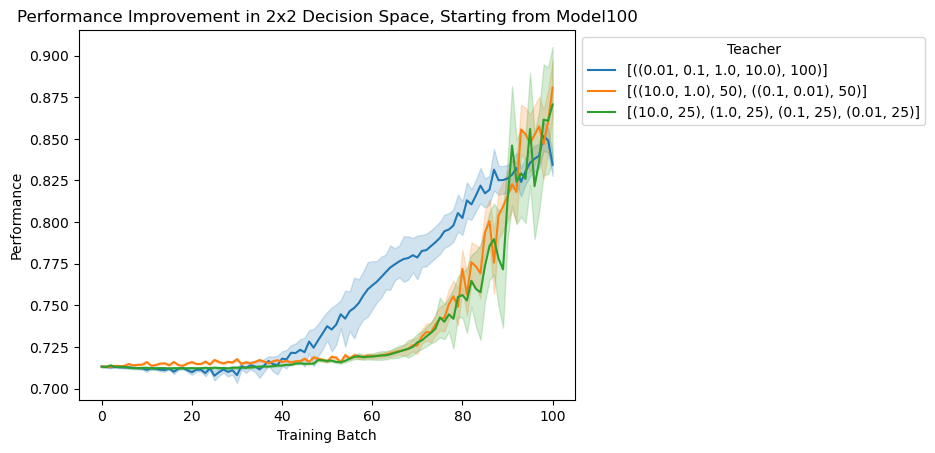

In [885]:
subs['two1'] = [str([(k, int(v)) for k,v in i]) for i in [
    [((0.010,0.100,1.000,10.00), nb)],
    [((10.00,1.000), nb//2), ((0.100,0.010), nb//2)],
    [(10.00, nb//4), (1.000, nb//4), (0.100, nb//4), (0.010, nb//4)],
]]
df2 = df[df.Teacher.isin(subs['two1']) & (df.Pct == 0)]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

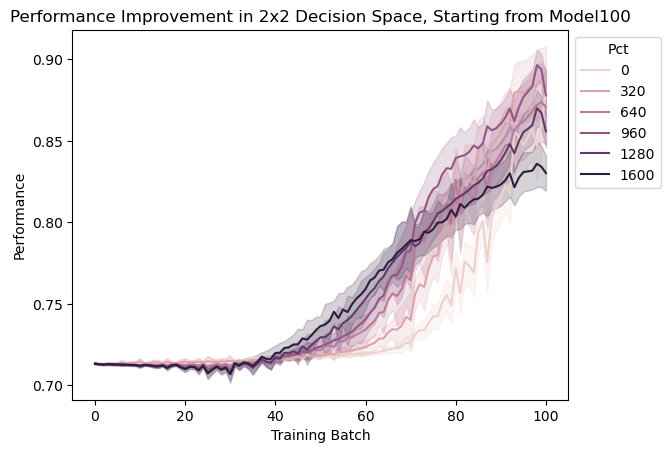

In [886]:
subs['two1'] = [str([(k, int(v)) for k,v in i]) for i in [
    [((10.00,1.000), nb//2), ((0.100,0.010), nb//2)],
]]
df2 = df[df.Teacher.isin(subs['two1'])]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Pct', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

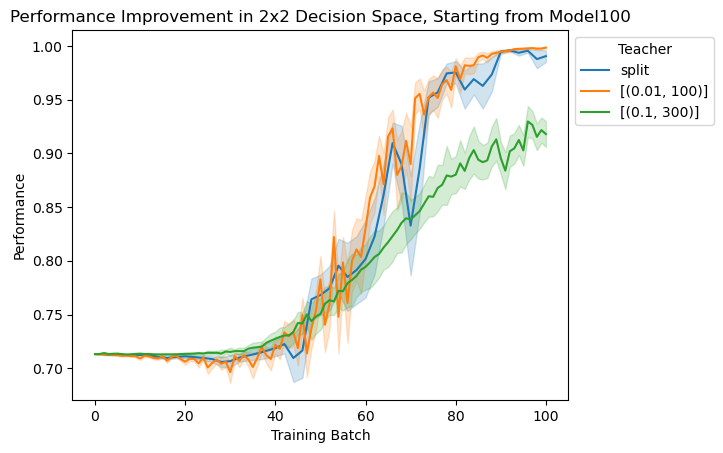

In [928]:
subs['three1'] = [str([(0.1, i), (0.01, i)]) for i in range(1, nb//2+1)]
df2_1 = df[df.Teacher.isin(subs['three1'])].copy()
df2_1['Teacher'] = 'split'
df2_2 = df[df.Teacher == f'[(0.01, {nb})]']
df2_3 = df[df.Teacher == f'[(0.1, {nb*3})]']
df2_3 = df2_3[df2_3.Batch <= 100].copy()
df2_3['Batch'] = df2_3['Batch'] / 1
df2 = pd.concat([df2_1, df2_2, df2_3])

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

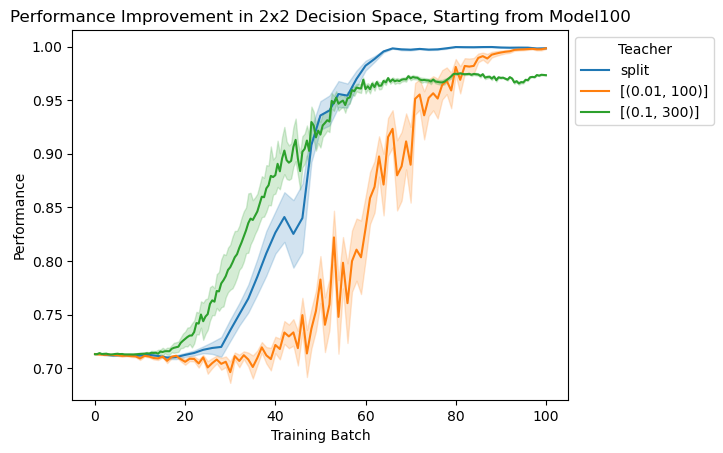

In [935]:
subs['three2'] = [str([(0.1, i*2), (0.01, i)]) for i in range(1, nb//2+1)]
df2_1 = df[df.Teacher.isin(subs['three2'])].copy()
df2_1['Teacher'] = 'split'
df2_1['Batch'] = df2_1.Batch * 2//3
df2_2 = df[df.Teacher == f'[(0.01, {nb})]']
df2_3 = df[df.Teacher == f'[(0.1, {nb*3})]']
df2_3 = df2_3[df2_3.Batch <= 200].copy()
df2_3['Batch'] = df2_3['Batch'] / 2
df2 = pd.concat([df2_1, df2_2, df2_3])

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

In [703]:
%%time
def analyze(student, n, num_batches, mode, algo=None):
    res = exp(student, n=n, nb=num_batches, mode=mode, algo=algo)
    res2 = []
    for i, s, t, d in res:
        s = f"{s:.3f}"
        t = str(t)
        for k, v in d.items():
            res2.append([s, t, i, k, v])
    df = pd.DataFrame(res2, columns=['Student','Teacher','Exp','Batch','Perf'])
    
    df2 = df.groupby(['Teacher','Batch']).Perf.mean().reset_index()
    df2['Perf2'] = df2.groupby('Teacher')['Perf'].transform(lambda x: x.rolling(10,1).mean())
    df2.Perf2 -= df2[df2.Batch==0].Perf2.mean()
    df2.Perf -= df2[df2.Batch==0].Perf.mean()
    
    return df, df2

CPU times: user 0 ns, sys: 49 µs, total: 49 µs
Wall time: 63.2 µs


In [536]:
n = 1000

  0%|          | 0/7000 [00:00<?, ?it/s]

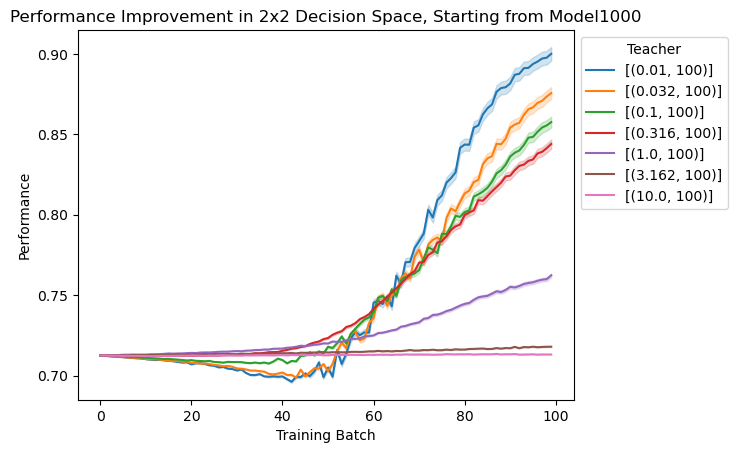

In [537]:
df, df2 = analyze(student=1000, n=n, num_batches=100, mode='one')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model1000',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/7000 [00:00<?, ?it/s]

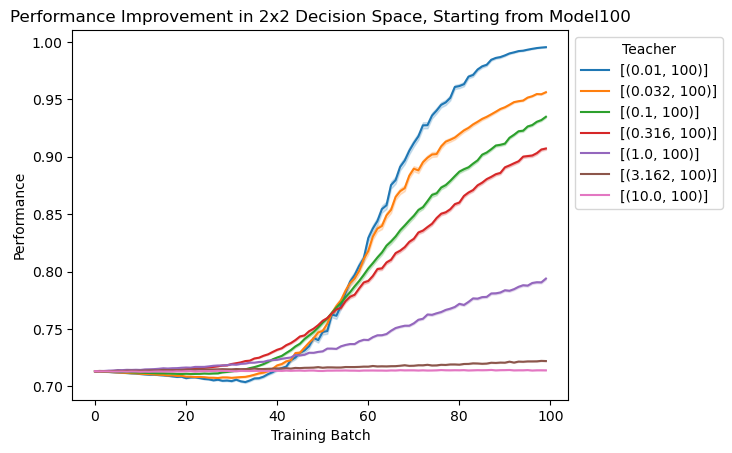

In [538]:
df, df2 = analyze(student=100, n=n, num_batches=100, mode='one')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/700 [00:00<?, ?it/s]

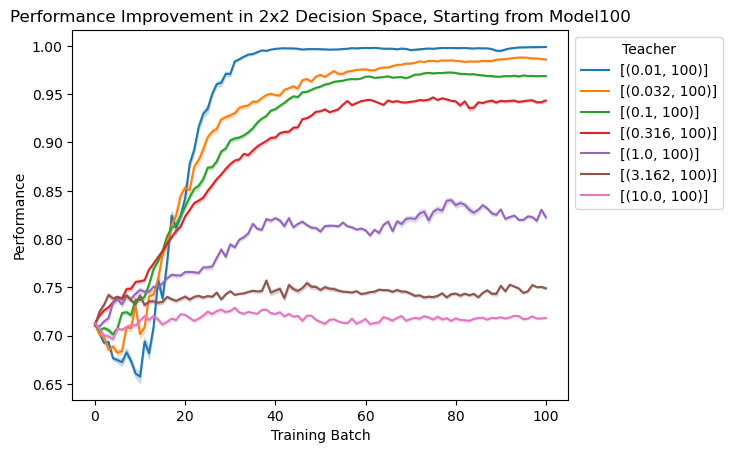

In [747]:
df, df2 = analyze(student=-1, n=n//10, num_batches=100, mode='one')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/700 [00:00<?, ?it/s]

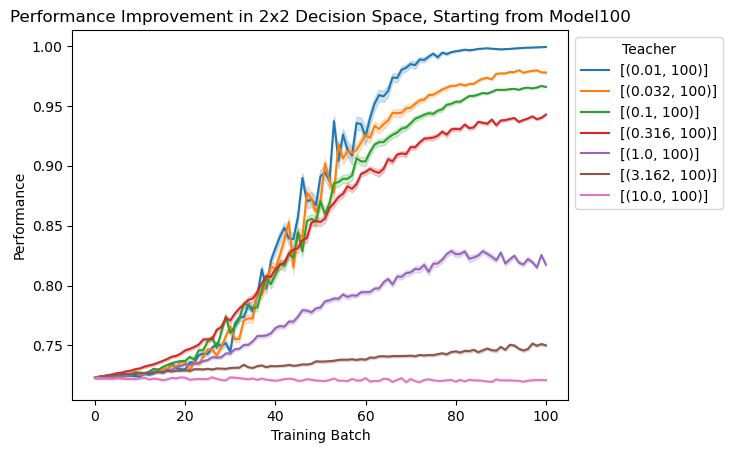

In [748]:
df, df2 = analyze(student=10, n=n//10, num_batches=100, mode='one')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

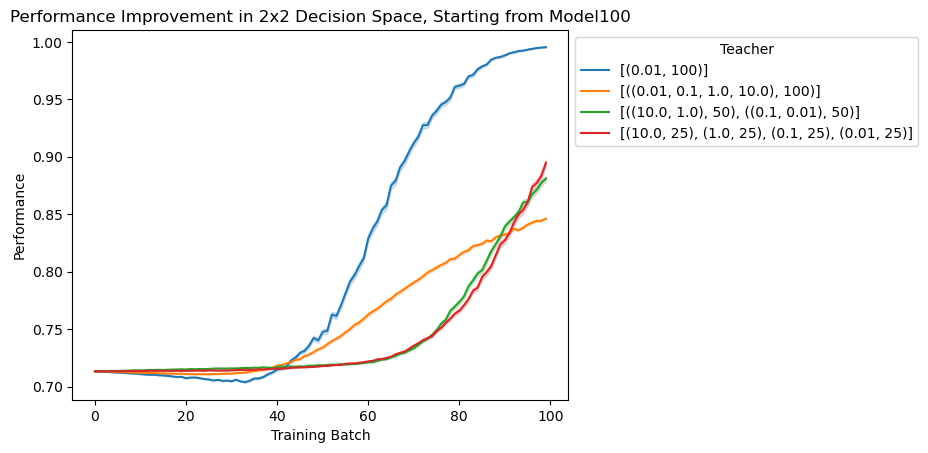

In [539]:
df, df2 = analyze(student=100, n=n, num_batches=100, mode='two')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

In [ ]:
df, df2 = analyze(student=100, n=n, num_batches=100, mode='two-2')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

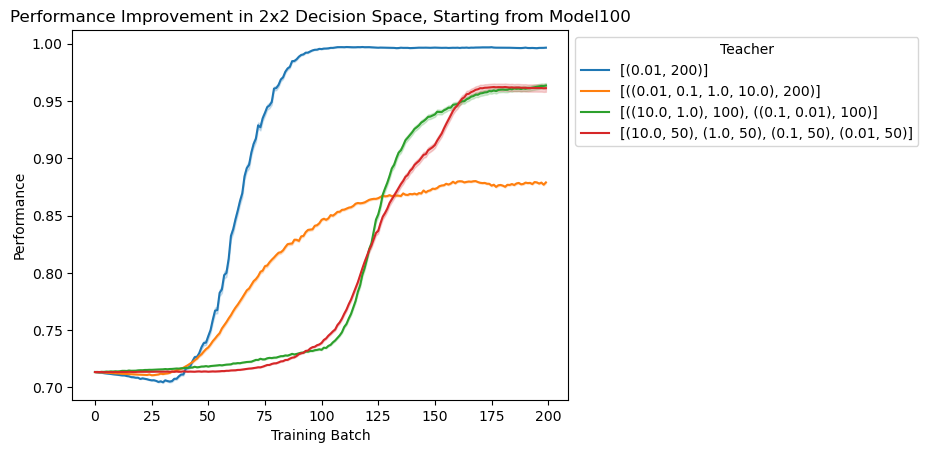

In [540]:
df, df2 = analyze(student=100, n=n, num_batches=200, mode='two')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/10000 [00:00<?, ?it/s]

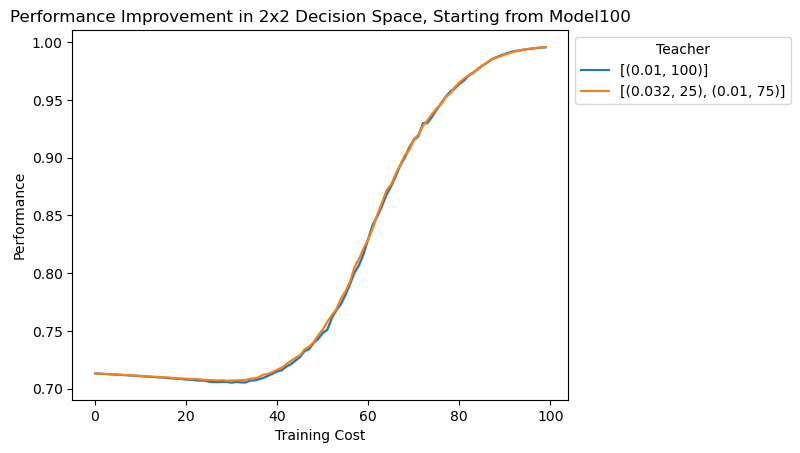

In [596]:
df, df2 = analyze(student=100, n=n*5, num_batches=100, mode='three-1')

df = df[~df.Perf.isna()]
df['Batch2'] = df.apply(adjust, axis=1)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch2', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Cost',
        ylabel='Performance'
    )

  0%|          | 0/300 [00:00<?, ?it/s]

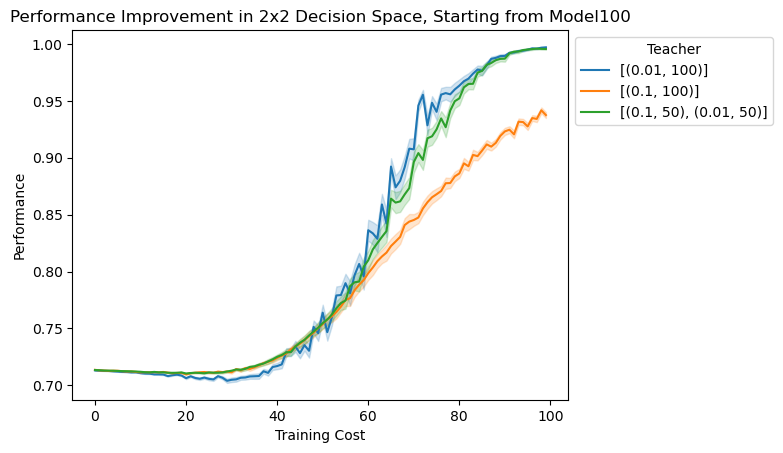

In [580]:
df, df2 = analyze(student=100, n=n, num_batches=100, mode='three-2')

df = df[~df.Perf.isna()]
df['Batch2'] = df.apply(adjust, axis=1)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch2', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Cost',
        ylabel='Performance'
    )

  0%|          | 0/700 [00:00<?, ?it/s]

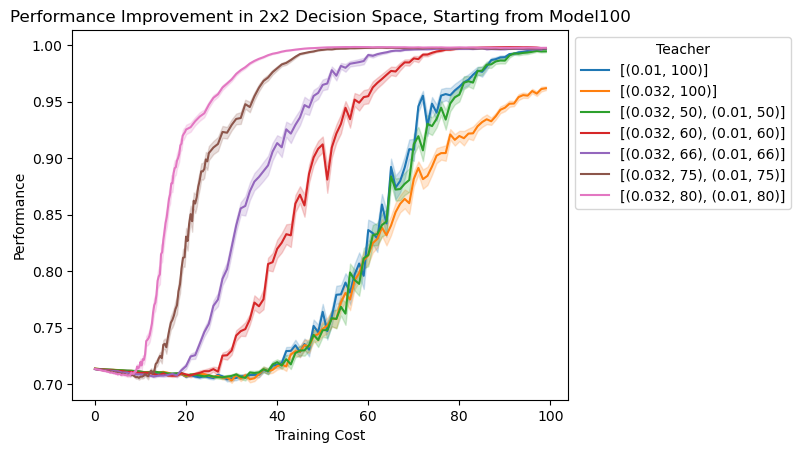

In [577]:
df, df2 = analyze(student=100, n=n//10, num_batches=100, mode='three-3')

df = df[~df.Perf.isna()]
df['Batch2'] = df.apply(adjust, axis=1)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch2', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Cost',
        ylabel='Performance'
    )

  0%|          | 0/700 [00:00<?, ?it/s]

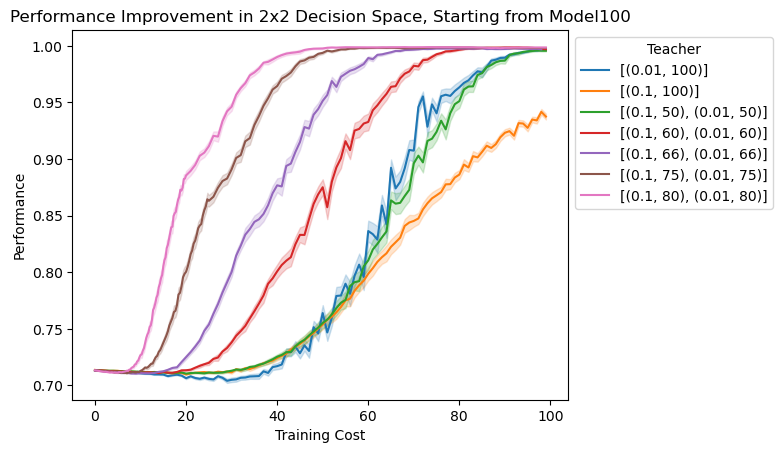

In [578]:
df, df2 = analyze(student=100, n=n//10, num_batches=100, mode='three-4')

df = df[~df.Perf.isna()]
df['Batch2'] = df.apply(adjust, axis=1)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch2', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Training Cost',
        ylabel='Performance'
    )

In [ ]:
n1, n2 = 5, 5

print(n1, n2)

while n1+n2 < 50:
    df, df2 = analyze(student=100, n=n//10, num_batches=None, mode='algo', algo=(n1,n2,5))
    best = df.groupby(['Teacher']).Perf.mean().sort_values(ascending=False).index[0]
    best = eval(best)
    n1 = sum([v for k,v in best if k==0.1]) // 2
    n2 = sum([v for k,v in best if k==0.01])
    print(n1, n2)

5 5


  0%|          | 0/200 [00:00<?, ?it/s]

10 5


  0%|          | 0/200 [00:00<?, ?it/s]

15 5


  0%|          | 0/200 [00:00<?, ?it/s]

20 5


  0%|          | 0/200 [00:00<?, ?it/s]

25 5


  0%|          | 0/200 [00:00<?, ?it/s]

30 5


  0%|          | 0/200 [00:00<?, ?it/s]

35 5


  0%|          | 0/200 [00:00<?, ?it/s]

In [701]:
df.groupby(['Teacher']).Perf.mean().reset_index().sort_values('Perf').iloc

Teacher
[(0.1, 10), (0.01, 45)]    0.802334
[(0.1, 20), (0.01, 40)]    0.837256
[(0.1, 30), (0.01, 35)]    0.857035
[(0.1, 40), (0.01, 30)]    0.903381
[(0.1, 50), (0.01, 25)]    0.927920
[(0.1, 60), (0.01, 20)]    0.942013
[(0.1, 70), (0.01, 15)]    0.952148
[(0.1, 80), (0.01, 10)]    0.940417
[(0.1, 90), (0.01, 5)]     0.943446
Name: Perf, dtype: float64

In [741]:
df, df2 = analyze(student=100, n=n//10, num_batches=50, mode='solution')
df['Teacher2'] = df.Teacher.apply(lambda x: (sum(v for k,v in eval(x) if k==0.1),
                                             sum(v for k,v in eval(x) if k==0.01)))
df.groupby(['Teacher2']).Perf.mean().reset_index()

  0%|          | 0/1100 [00:00<?, ?it/s]

,Teacher2,Perf
0,"(0, 50)",0.758373
1,"(10, 45)",0.785140
2,"(20, 40)",0.820125
3,"(30, 35)",0.880411
4,"(40, 30)",0.896051
5,"(50, 25)",0.919855
6,"(60, 20)",0.951383
7,"(70, 15)",0.950039
8,"(80, 10)",0.948168
9,"(90, 5)",0.938519


In [576]:
def adjust(row):
    
    if len(eval(row.Teacher)) == 2:
        (_, n), _ = eval(row.Teacher)
        
        
        if n%60 == 0:
            if row.Batch < n:
                return row.Batch // 1.5
            else:
                return row.Batch - n // 3
            
        if n%66 == 0:
            if row.Batch < n:
                return row.Batch // 2
            else:
                return row.Batch - n // 2
            
        if n%75 == 0:
            if row.Batch < n:
                return row.Batch / 3
            else:
                return row.Batch - n * 2 // 3
            
        if n%80 == 0:
            if row.Batch < n:
                return row.Batch / 4
            else:
                return row.Batch - n * 3 // 4
    
#     if row.Teacher == '[(0.1, 66), (0.01, 66)]':
#         if row.Batch < 66:
#             return row.Batch / 2
#         else:
#             return row.Batch - 33
#     if row.Teacher == '[(0.1, 132), (0.01, 132)]':
#         if row.Batch < 132:
#             return row.Batch / 2
#         else:
#             return row.Batch - 66
        
#     if row.Teacher == '[(0.1, 75), (0.01, 75)]':
#         if row.Batch < 75:
#             return row.Batch / 3
#         else:
#             return row.Batch - 50
#     if row.Teacher == '[(0.1, 150), (0.01, 150)]':
#         if row.Batch < 150:
#             return row.Batch / 3
#         else:
#             return row.Batch - 100
        
#     if row.Teacher == '[(0.1, 80), (0.01, 80)]':
#         if row.Batch < 80:
#             return row.Batch / 4
#         else:
#             return row.Batch - 60
#     if row.Teacher == '[(0.1, 160), (0.01, 160)]':
#         if row.Batch < 160:
#             return row.Batch / 4
#         else:
#             return row.Batch - 120
        
    return row.Batch

# 2x10

In [369]:
n = 500

  0%|          | 0/3500 [00:00<?, ?it/s]

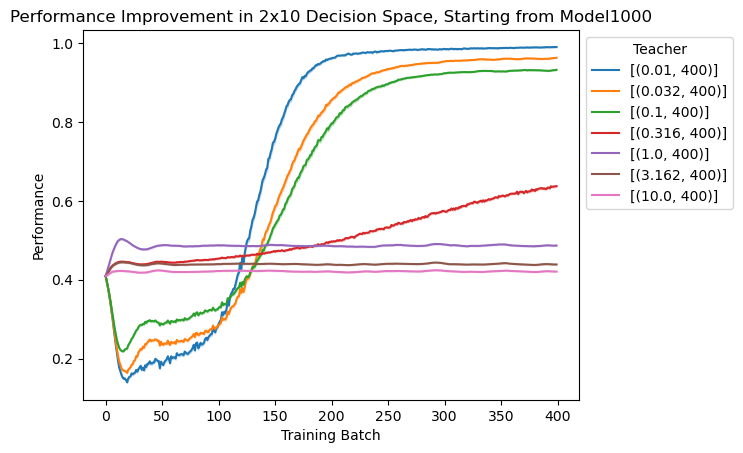

In [370]:
df, df2 = analyze(student=100, n=n, num_batches=400, mode='one')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model1000',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

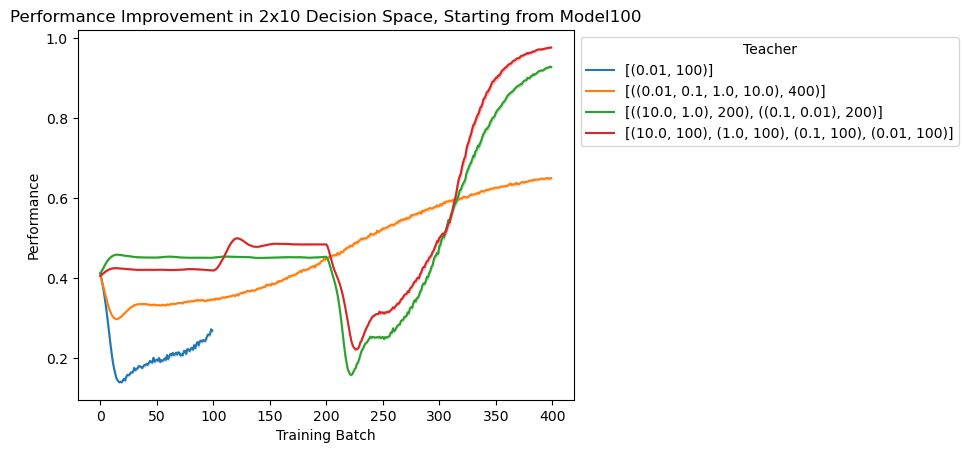

In [371]:
df, df2 = analyze(student=100, n=n, num_batches=400, mode='two')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

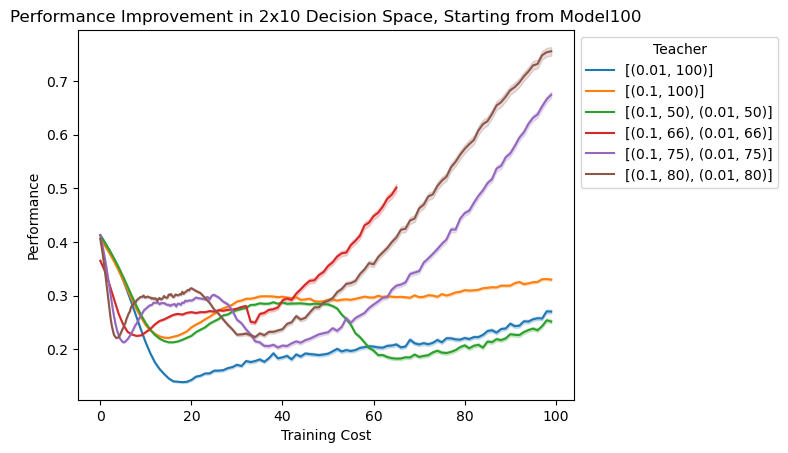

In [372]:
df, df2 = analyze(student=100, n=n, num_batches=100, mode='three')

df = df[~df.Perf.isna()]
df['Batch2'] = df.apply(adjust, axis=1)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch2', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model100',
        xlabel='Training Cost',
        ylabel='Performance'
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

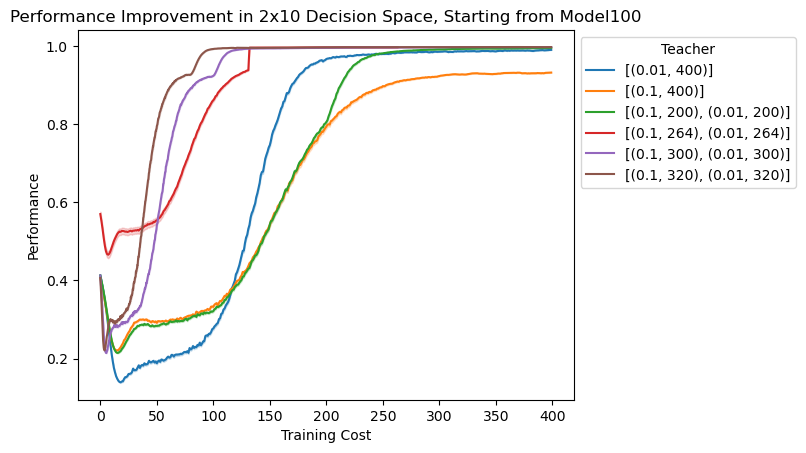

In [373]:
df, df2 = analyze(student=100, n=n, num_batches=400, mode='three')

df = df[~df.Perf.isna()]
df['Batch2'] = df.apply(adjust, axis=1)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch2', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model100',
        xlabel='Training Cost',
        ylabel='Performance'
    )